<a href="https://colab.research.google.com/github/jomscan/CEIABDTA/blob/main/Proyecto_Fin_de_Especializaci%C3%B3n_V_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importaciones de librerias

---




In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import re
import math
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

##Importar dataset desde Driver

---



In [2]:
# -----------------------------
# -------- Script principal -------
# -----------------------------

# Cargar los ficheros train y test (ajusta las rutas según corresponda)
# Para Google Colab, primero necesitas subir los archivos o descargarlos

# Descargar datos de una URL o usar datos cargados manualmente
# Opción 1: Descargar datos (descomenta si es necesario)
"""
!wget -O train_values.csv URL_DEL_ARCHIVO
!wget -O train_labels.csv URL_DEL_ARCHIVO
!wget -O test_values.csv URL_DEL_ARCHIVO
"""

# Opción 2: Subir datos desde tu computadora a Colab
from google.colab import drive
drive.mount('/content/drive')

csv_path1 = '/content/drive/MyDrive/Proyecto Fin de Especialización /datos/Valores del conjunto de entrenamiento.csv'
csv_path2 = '/content/drive/MyDrive/Proyecto Fin de Especialización /datos/Etiquetas del conjunto de entrenamiento.csv'
csv_path3 = '/content/drive/MyDrive/Proyecto Fin de Especialización /datos/Valores del conjunto de prueba.csv'

# Leer los datos
train_values = pd.read_csv(csv_path1)
train_labels = pd.read_csv(csv_path2)
test_values = pd.read_csv(csv_path3)

Mounted at /content/drive


## Primer Analisis

---




--- Información general de los datos de entrenamiento ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  


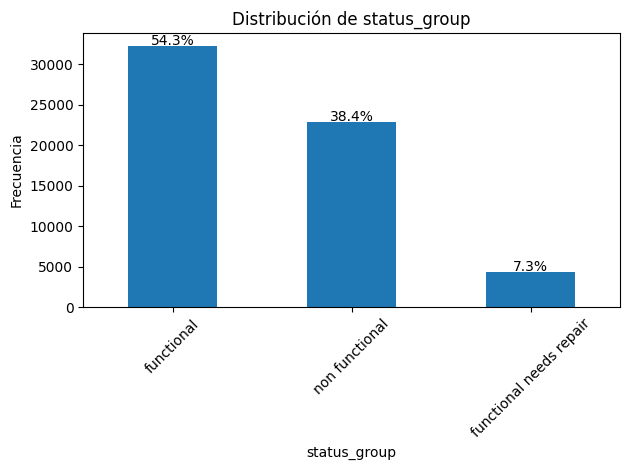

In [3]:
# Combina las características y las etiquetas de entrenamiento
df_train = pd.merge(train_values, train_labels, on='id')

print("\n--- Información general de los datos de entrenamiento ---")
print(df_train.info())

print("\n--- Primeras 5 filas de los datos de entrenamiento ---")
print(df_train.head())

print("\n--- Primeras 5 filas de los datos de prueba ---")
print(test_values.head())

print("\n--- Distribución de la variable objetivo (status_group) en entrenamiento ---")
print(df_train['status_group'].value_counts(normalize=True))

# Gráfica de barras con porcentaje en las columnas
counts = df_train['status_group'].value_counts()
percentages = (counts / counts.sum()) * 100

ax = counts.plot(kind='bar')
plt.title('Distribución de status_group')
plt.xlabel('status_group')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

# Añadir etiquetas con porcentaje en cada barra
for i, (count, percent) in enumerate(zip(counts, percentages)):
    plt.text(i, count + 100, f'{percent:.1f}%', ha='center')

plt.tight_layout()
plt.show()

Paso 1:

Esto nos da una visión clara de los datos.


*   Tamaño del Dataset: 59,400 entradas de entrenamiento, con 41 columnas.


Tipos de Datos:


*   int64: id, gps_height, num_private, region_code, district_code, population, construction_year.
*   float64: amount_tsh, longitude, latitude.
*   object: La mayoría de las columnas son de tipo object, lo que significa que son categóricas (cadenas de texto). Estas necesitarán ser codificadas numéricamente para el Random Forest.



Valores Faltantes (Non-Null Count):


*   funder (55763 non-null de 59400) - ~6% faltante.
*   installer (55745 non-null de 59400) - ~6% faltante.
*   wpt_name (59398 non-null de 59400) - Muy pocos faltantes, probablemente se puedan ignorar o imputar con la moda.
*   subvillage (59029 non-null de 59400) - ~0.6% faltante.
*   public_meeting (56066 non-null de 59400) - ~5.6% faltante.
*   scheme_management (55522 non-null de 59400) - ~6.5% faltante.
*   scheme_name (30590 non-null de 59400) - ¡Casi la mitad de los valores faltan! Esto es significativo.
*   permit (56344 non-null de 59400) - ~5.1% faltante.
*   Variable Objetivo (status_group):

functional: 54.3%
non functional: 38.4%
functional needs repair: 7.2%

Hay un desequilibrio de clases. La clase "functional needs repair" es minoritaria. Esto es importante para la evaluación y posiblemente para el entrenamiento del modelo.

Paso 2: Preprocesamiento de Datos y Feature Engineering (Ingeniería de Características)

Ahora que conozco los datos, voy a preparar las características para el modelo. Esto incluye:

*   Manejo de Valores Faltantes: Decidir cómo imputar o manejar las columnas con NaN.
*   Codificación de Variables Categóricas: Convertir las columnas object a un formato numérico.
*   Manejo de la Columna date_recorded: Convertir a un formato útil (por ejemplo, año, mes, día, antigüedad del pozo).
*  Manejo de Variables con 0 en Columnas Numéricas que Deberían ser Positivas: Columnas como longitude, latitude, gps_height, population, construction_year pueden tener valores 0 que no son significativos y podrían indicar datos faltantes o incorrectos.



Voy a implementar algunas estrategias iniciales:

## Ingenieria de los datos


---



In [4]:
# Importar librerías adicionales que necesitaremos
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Función de Preprocesamiento ---
def preprocess_data(df):
    df = df.copy() # Trabajar con una copia para evitar SettingWithCopyWarning

    # 1. Manejo de 'id' (no es una característica, se usará para la submission)
    if 'id' in df.columns:
        df_id = df['id']
    else:
        df_id = None

    # 2. Manejo de Valores Faltantes y Ceros no Significativos
    # Reemplazar 0 en 'longitude', 'latitude', 'population', 'gps_height', 'construction_year' con NaN para imputación
    # En la competencia se ha notado que 0 en longitud/latitud pueden ser datos faltantes
    df['longitude'] = df['longitude'].replace(0, np.nan)
    df['latitude'] = df['latitude'].replace(0, np.nan)
    df['gps_height'] = df['gps_height'].replace(0, np.nan) # 0 puede ser un valor de sensor defectuoso
    df['population'] = df['population'].replace(0, np.nan)
    df['construction_year'] = df['construction_year'].replace(0, np.nan) # 0 significa desconocido o no registrado


    # 3. Feature Engineering de 'date_recorded'
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day
    # Calcular la "edad" del pozo al momento del registro
    # Esto asume que el año de construcción es una fecha de inicio
    # Impute construction_year si es necesario antes de esto, o manejare NaNs.
    # Por ahora, si construction_year es NaN, la edad también lo será.
    df['age_pump'] = df['year_recorded'] - df['construction_year']
    df['age_pump'] = df['age_pump'].replace([np.inf, -np.inf], np.nan) # Eliminar infs si construction_year es futuro por error

    # 4. Manejo de Columnas con Muy Pocos Valores Únicos o Muy Altos
    # 'recorded_by' parece tener un solo valor 'GeoData Consultants Ltd', por lo que no aporta información.
    if 'recorded_by' in df.columns:
        df = df.drop('recorded_by', axis=1)

    # 'num_private' tiene muy pocos valores únicos y la mayoría son 0. Podría ser de baja utilidad.
    # Por ahora la mantengo, pero es candidata a ser eliminada si el rendimiento es bajo.

    # 5. Columnas con Redundancia
    # Algunas columnas son casi duplicados o grupos de otras (e.g., extraction_type, extraction_type_group, extraction_type_class)
    # Dejo una de cada grupo que parezca más representativa o con menos cardinalidad/NaNs.
    # Por ahora, dejo todas, pero es algo a considerar.
    # Sin embargo, 'quantity' y 'quantity_group' son idénticas. Elimino una.
    if 'quantity_group' in df.columns:
        df = df.drop('quantity_group', axis=1)
    if 'waterpoint_type_group' in df.columns:
        df = df = df.drop('waterpoint_type_group', axis=1) # waterpoint_type parece más granular
    if 'quality_group' in df.columns:
        df = df.drop('quality_group', axis=1) # water_quality parece más granular
    if 'management_group' in df.columns:
        df = df.drop('management_group', axis=1) # management parece más granular
    if 'extraction_type_group' in df.columns:
        df = df.drop('extraction_type_group', axis=1) # extraction_type o extraction_type_class pueden ser mejores
    if 'payment_type' in df.columns: # payment y payment_type son muy similares
        df = df.drop('payment_type', axis=1)
    if 'source_type' in df.columns: # source y source_type son muy similares
        df = df.drop('source_type', axis=1)

    # 6. Columnas de alta cardinalidad o con muchos NaN que pueden ser problemáticas
    # 'scheme_name' tiene casi el 50% de NaNs. La imputación con la moda podría no ser muy útil.
    # La puedo imputar como 'unknown' o eliminarla si causa problemas. Para RF, puedo imputar como 'unknown'.
    # 'wpt_name' también tiene alta cardinalidad. 'subvillage' también.
    # Las imputare con una categoría 'unknown' para las categóricas con NaNs o 'missing' para numéricas con NaNs.

    # Identifica columnas categóricas y numéricas (después de feature engineering)
    # Excluye 'id' y 'status_group' si están presentes
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Eliminar 'id' y 'status_group' de las listas si están presentes
    if 'id' in numeric_cols:
        numeric_cols.remove('id')
    if 'status_group' in categorical_cols: # Es la variable objetivo, no una feature
        categorical_cols.remove('status_group')


    # Define el preprocesador para el pipeline
    # Imputación para numéricas: mediana
    # Imputación para categóricas: la más frecuente ('most_frequent') para aquellas con pocos nulos,
    # y una categoría constante 'missing' para las con muchos nulos o que decidimos imputar así.
    # One-Hot Encoding para categóricas.

    # Imputadores específicos
    # Para NaNs generados por 0s, la mediana puede ser una buena opción.
    numeric_imputer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])

    # Para categóricas: 'funder', 'installer', 'public_meeting', 'scheme_management', 'permit', 'scheme_name'
    # 'wpt_name', 'subvillage'
    # Usare 'most_frequent' para la mayoría, y 'constant' para 'scheme_name' por la alta cantidad de NaNs
    categorical_imputer_most_frequent = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    categorical_imputer_constant = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) # Para scheme_name
    ])


    # Column Transformer para aplicar transformaciones diferentes a diferentes columnas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_imputer, numeric_cols), # Imputa numéricas con la mediana
            ('cat_most_freq', categorical_imputer_most_frequent, ['funder', 'installer', 'wpt_name', 'subvillage', 'public_meeting', 'scheme_management', 'permit']),
            ('cat_constant', categorical_imputer_constant, ['scheme_name']),
            ('cat_ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols) # Aplica OneHotEncoder a todas las categóricas
            # Las columnas que ya pasaron por el imputer y son categóricas (como funder, installer, etc.) ya no necesitan un imputer aquí
            # Solo necesitan el OneHotEncoder.
        ],
        remainder='passthrough' # Mantiene columnas que no se especifican (como 'id' si la incluimos por error)
    )

    # Retorna el DataFrame procesado y el ID si es el df de test
    if df_id is not None:
        return df, df_id, preprocessor, numeric_cols, categorical_cols
    else:
        return df, preprocessor, numeric_cols, categorical_cols


# --- Aplicar el preprocesamiento ---
# Para el conjunto de entrenamiento
df_train_processed, _, preprocessor_for_fit, numeric_cols_train, categorical_cols_train = preprocess_data(df_train)

# Para el conjunto de prueba (necesito los IDs para la submission)
df_test_processed, test_ids, _, _, _ = preprocess_data(test_values)

print("\n--- Columnas del DataFrame de Entrenamiento después del preprocesamiento (antes de la transformación final) ---")
print(df_train_processed.columns)
print("\n--- Columnas numéricas identificadas:", numeric_cols_train)
print("\n--- Columnas categóricas identificadas (antes de OneHotEncoder):", categorical_cols_train)

# Mapear la variable objetivo a valores numéricos
label_encoder = LabelEncoder()
df_train['status_group_encoded'] = label_encoder.fit_transform(df_train['status_group'])
# Guardar el mapeo para la interpretación posterior
status_group_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nMapeo de status_group a números:", status_group_mapping)


# Ahora, para construir el pipeline final y entrenar el modelo
# Defino X (características) e y (variable objetivo)
# Excluyo 'id' y 'status_group' (original) de X
X_train_pre = df_train_processed.drop(columns=['id', 'status_group'], errors='ignore')
y_train = df_train['status_group_encoded']
X_test_pre = df_test_processed.drop(columns=['id'], errors='ignore') # El test set no tiene status_group

# Verifico que las columnas de X_train_pre y X_test_pre son las mismas
# Es CRÍTICO que los ColumnTransformer reciban los DataFrames con las mismas columnas y en el mismo orden
# Asegurémonos de que las columnas pasadas al preprocessor sean las correctas.
# Para el column transformer, lo ideal es pasar las columnas que ya procesamos y luego el resto
# La forma más segura es crear listas de columnas para el preprocessor, que sean consistentes.
# Voy a rehacer la definición del preprocessor para que sea más robusta y no dependa del `remainder='passthrough'` de forma compleja.

# Las columnas de features que usaremos
features_to_process = X_train_pre.columns.tolist()

# Separar las columnas en numéricas y categóricas *después* de las operaciones de feature engineering
# pero *antes* de que se aplique OneHotEncoder, para que el ColumnTransformer sepa qué imputar.
# Aquí necesito re-identificar los tipos de columnas en el DF ya transformado (X_train_pre, X_test_pre)
# Y luego aplicarle el ColumnTransformer a estas columnas.

# La manera correcta es definir las listas de columnas para el ColumnTransformer antes de crear el preprocessor
# y asegurarnos que preprocess_data *no* elimine columnas importantes que luego queremos procesar.
# El `preprocess_data` debería devolver el df limpio para el ColumnTransformer.

# Volvamos a definir las listas de columnas que el ColumnTransformer necesita,
# basadas en el conocimiento de df_train_processed (y df_test_processed).

# Re-identificar columnas después de la primera fase de limpieza pero antes del ColumnTransformer
# Esto es para asegurar que el preprocessor usa las columnas correctas.

# Asignar 'object' como NaN a la columna 'funder', 'installer', etc.
for col in ['funder', 'installer', 'wpt_name', 'subvillage', 'public_meeting', 'scheme_management', 'permit', 'scheme_name']:
    if col in X_train_pre.columns:
        X_train_pre[col] = X_train_pre[col].replace('NaN', np.nan) # Asegurar que los 'NaN' string sean np.nan
        X_test_pre[col] = X_test_pre[col].replace('NaN', np.nan)


# Re-identificar columnas para el ColumnTransformer después de las transformaciones iniciales
# Excluir 'id', 'status_group', 'date_recorded' y 'status_group_encoded' (si existe en X_train_pre)
# Y las columnas eliminadas por redundancia
all_features = [col for col in X_train_pre.columns if col not in ['id', 'date_recorded']] # 'id' ya fue quitado, 'date_recorded' ya fue transformada
X_train_final_features = X_train_pre[all_features]
X_test_final_features = X_test_pre[all_features]


# Identificar columnas numéricas y categóricas para el preprocessor final
# Este paso es crucial para que el ColumnTransformer aplique las transformaciones correctas.
numeric_features_for_ct = X_train_final_features.select_dtypes(include=np.number).columns.tolist()
categorical_features_for_ct = X_train_final_features.select_dtypes(exclude=np.number).columns.tolist()


# Ahora defino el preprocessor de forma más robusta
# Ya manejo los 0s a NaNs y feature engineering de fechas y redundancia fuera del CT para mayor claridad
# El CT ahora se encargará de la imputación y codificación final.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features_for_ct), # Imputar numéricas con la mediana
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')), # Imputar categóricas con la moda
            ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-Hot Encoding
        ]), categorical_features_for_ct)
    ],
    remainder='passthrough' # Mantiene columnas que no se especifican (no debería haber ninguna si definimos bien)
)

print("\n--- Columnas numéricas para ColumnTransformer:", numeric_features_for_ct)
print("--- Columnas categóricas para ColumnTransformer:", categorical_features_for_ct)


# --- Paso 3: Dividir los Datos (para validación) ---
# Usare una división simple de entrenamiento y validación para evaluar el modelo localmente
# antes de crear la predicción final para DrivenData.
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_final_features, y_train, test_size=0.2, random_state=42, stratify=y_train
)
# Uso stratify=y_train para asegurar que la distribución de clases sea similar en ambos conjuntos.

print(f"\nDimensiones de X_train_split: {X_train_split.shape}")
print(f"Dimensiones de X_val_split: {X_val_split.shape}")
print(f"Dimensiones de y_train_split: {y_train_split.shape}")
print(f"Dimensiones de y_val_split: {y_val_split.shape}")

print("\n--- Distribución de la variable objetivo en X_train_split ---")
print(pd.Series(y_train_split).value_counts(normalize=True))
print("\n--- Distribución de la variable objetivo en X_val_split ---")
print(pd.Series(y_val_split).value_counts(normalize=True))


--- Columnas del DataFrame de Entrenamiento después del preprocesamiento (antes de la transformación final) ---
Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type', 'status_group',
       'year_recorded', 'month_recorded', 'day_recorded', 'age_pump'],
      dtype='object')

--- Columnas numéricas identificadas: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'age_pump']

--- Columnas categóricas identificadas (antes de OneHotEncoder): ['funder', 'installer', 'wpt

Explicación :

Función preprocess_data:
*   Manejo de Ceros a NaN: Convertimos los 0 en longitude, latitude, gps_height, population y construction_year a np.nan. Esto es importante porque un 0 en estas columnas a menudo no significa un valor real de cero, sino un dato faltante o incorrecto. Random Forest puede interpretar un 0 como un valor significativo.
*   Feature Engineering de date_recorded: Extraemos el año, mes, día y calculamos la age_pump (edad del pozo). Esto convierte una fecha en características numéricas útiles.
*   Eliminación de Columnas Redundantes/Inútiles: Eliminamos recorded_by (tiene un solo valor), y varias columnas _group que eran casi idénticas a sus contrapartes sin _group (ej. quantity_group vs quantity). Esto reduce la dimensionalidad y el ruido.

Devuelve el DataFrame transformado para que el ColumnTransformer (que es más potente para manejar diferentes tipos de imputación y codificación) pueda procesarlo.

LabelEncoder para la Variable Objetivo:

Convertimos la variable status_group (que es categórica: 'functional', 'non functional', 'functional needs repair') a valores numéricos (0, 1, 2). Esto es necesario para la mayoría de los modelos de machine learning. Guardamos el mapeo para poder interpretar las predicciones.

ColumnTransformer:

Es una herramienta poderosa de scikit-learn para aplicar diferentes transformaciones a diferentes columnas.

Numéricas: Las imputamos con la mediana (más robusta que la media para valores atípicos).

Categóricas: Las imputamos con la moda (valor más frecuente) y luego aplicamos OneHotEncoder. OneHotEncoder crea nuevas columnas binarias para cada categoría, lo cual es necesario para Random Forest (no sabe cómo manejar texto). handle_unknown='ignore' es crucial para el conjunto de prueba, en caso de que contenga categorías nuevas que no vio en el entrenamiento.

División de Datos (train_test_split):

Dividimos el conjunto de entrenamiento original en un conjunto de entrenamiento (X_train_split, y_train_split) y un conjunto de validación (X_val_split, y_val_split). Esto nos permite evaluar el rendimiento del modelo antes de enviarlo a DrivenData, sin "contaminar" las métricas del conjunto de prueba.
Usamos stratify=y_train porque tenemos un desequilibrio de clases en status_group. Esto asegura que la proporción de cada clase sea similar en los conjuntos de entrenamiento y validación.

Aquí un breve resumen de lo que veo y lo que significa:

Columnas Procesadas: El Index muestra que las columnas como year_recorded, month_recorded, day_recorded, y age_pump se crearon correctamente, y las columnas redundantes como quantity_group se eliminaron (aunque no se muestra explícitamente en el índice final si se eliminaron en el df_train_processed).

Identificación de Tipos para ColumnTransformer: Las listas numeric_features_for_ct y categorical_features_for_ct son correctas y listas para ser usadas por el ColumnTransformer. Es bueno ver que year_recorded, month_recorded, day_recorded, age_pump ahora están en las numéricas.

Dimensiones de los Datos: Las dimensiones de los conjuntos X_train_split, X_val_split, y_train_split, y_val_split son las esperadas, y la división 80/20 se realizó correctamente.

Distribución de Clases: La estratificación funcionó muy bien, manteniendo las proporciones de las clases objetivo ('functional', 'non functional', 'functional needs repair') casi idénticas en los conjuntos de entrenamiento y validación. Esto es crucial para un modelo robusto.

Mapeo de Clases: El mapeo {'functional': 0, 'functional needs repair': 1, 'non functional': 2} es claro y nos permitirá interpretar las predicciones numéricas del modelo.

Ahora estamos listos para el Paso 3: Entrenamiento del Modelo Random Forest y el Paso 4: Evaluación Inicial.

## Entrenamiento de modelo


--- Iniciando el entrenamiento del modelo Random Forest... ---
--- Entrenamiento del modelo Random Forest completado. ---

Precisión (Accuracy) en el conjunto de validación: 0.8116
F1-Score (Macro Average) en el conjunto de validación: 0.6908

Matriz de Confusión:
[[5806  124  522]
 [ 450  269  144]
 [ 945   53 3567]]


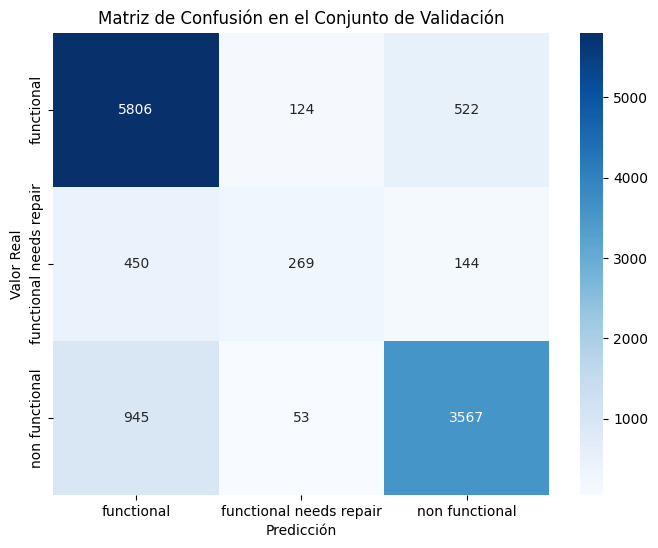


Reporte de Clasificación:
                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.60      0.31      0.41       863
         non functional       0.84      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880



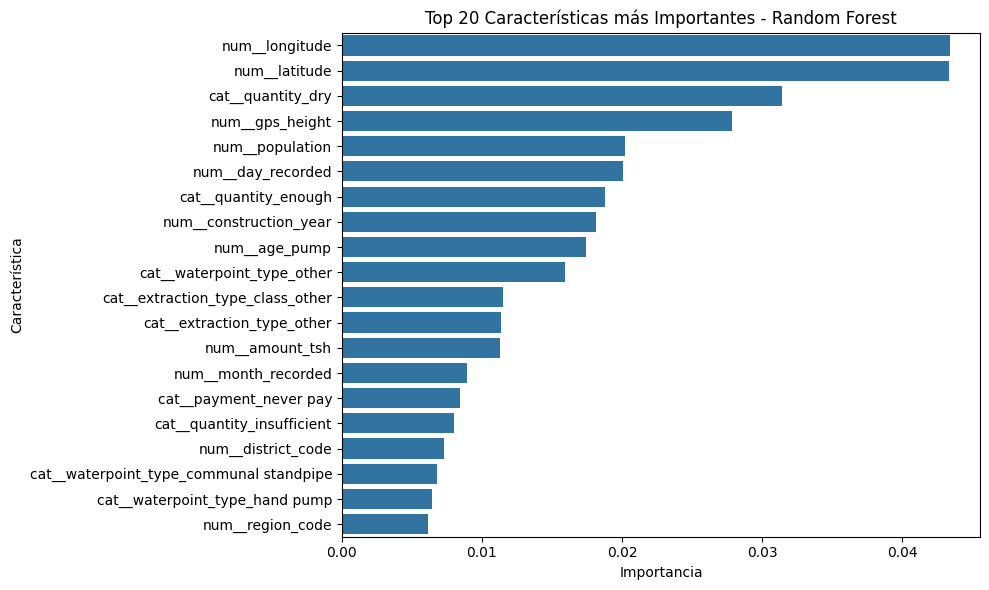

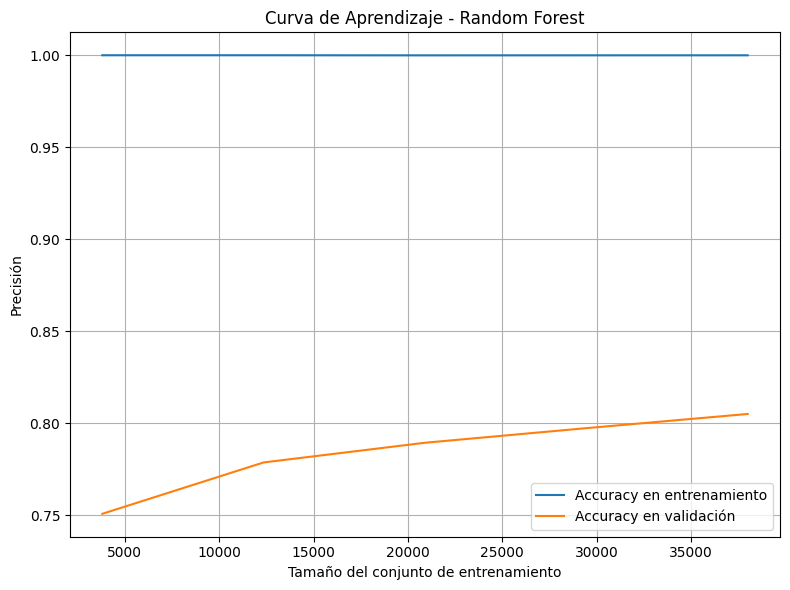

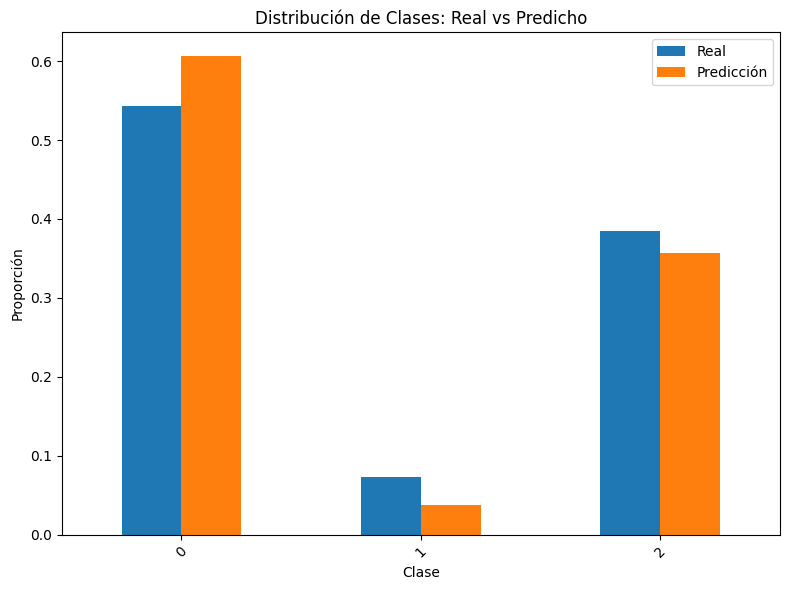


--- Realizando predicciones en el conjunto de prueba para el envío ---

Archivo de envío 'submission_random_forest_initial.csv' creado exitosamente.
      id    status_group
0  50785      functional
1  51630      functional
2  17168      functional
3  45559  non functional
4  49871      functional


In [5]:
# Importar el pipeline si aún no lo has hecho
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np # Asegurarse de que numpy está importado
from sklearn.model_selection import learning_curve


# Asegúrate de que las variables X_train_final_features, X_test_final_features, y_train, test_ids, preprocessor
# y label_encoder están disponibles de los pasos anteriores.
# Si estás ejecutando esto en un nuevo script/sesión, tendrás que ejecutar todo el código previo.

# --- Paso 3: Entrenamiento del Modelo Random Forest ---

# Creo un pipeline que primero preprocesa los datos y luego entrena el modelo
# Esto asegura que el preprocesamiento se aplique de forma consistente a ambos conjuntos de datos.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1)) # n_jobs=-1 usa todos los cores
                                ])

# Entreno el pipeline con los datos de entrenamiento
print("\n--- Iniciando el entrenamiento del modelo Random Forest... ---")
model_pipeline.fit(X_train_split, y_train_split)
print("--- Entrenamiento del modelo Random Forest completado. ---")


# --- Paso 4: Evaluación Inicial del Modelo ---

# Realizo predicciones en el conjunto de validación
y_val_pred_encoded = model_pipeline.predict(X_val_split)

# Calculo la precisión (accuracy)
accuracy = accuracy_score(y_val_split, y_val_pred_encoded)
print(f"\nPrecisión (Accuracy) en el conjunto de validación: {accuracy:.4f}")

# Calculo el F1-score (macro average)
# El F1-score es importante para el desequilibrio de clases,
# y 'macro' calcula el F1 para cada clase y luego promedia, dando igual peso a cada clase.
f1_macro = f1_score(y_val_split, y_val_pred_encoded, average='macro')
print(f"F1-Score (Macro Average) en el conjunto de validación: {f1_macro:.4f}")

# También podemos ver la matriz de confusión para entender los errores del modelo
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(y_val_split, y_val_pred_encoded)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Visualizar la matriz de confusión para una mejor comprensión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión en el Conjunto de Validación')
plt.show()

# Para entender los errores, también podemos ver el reporte de clasificación
from sklearn.metrics import classification_report
print("\nReporte de Clasificación:")
print(classification_report(y_val_split, y_val_pred_encoded, target_names=label_encoder.classes_))

# --- Gráfica 2: Importancia de características ---
# Extraigo el modelo Random Forest ya entrenado desde el pipeline
rf_model = model_pipeline.named_steps['classifier']

# Obtengo los nombres de características del preprocesador
feature_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Extraigo la importancia de cada característica desde el modelo
importances = rf_model.feature_importances_

# Creo un DataFrame y ordenamos por importancia descendente (top 20)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(20)

# Visualizamos las 20 características más importantes
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='importance', y='feature')
plt.title('Top 20 Características más Importantes - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# --- Gráfica 3: Curva de Aprendizaje ---
# Esta curva ayuda a detectar overfitting o underfitting evaluando el rendimiento con distintos tamaños de entrenamiento
train_sizes, train_scores, val_scores = learning_curve(
    model_pipeline, X_train_split, y_train_split,
    cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)

# Calculo el promedio de los scores de entrenamiento y validación
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Grafico ambas curvas
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Accuracy en entrenamiento')
plt.plot(train_sizes, val_mean, label='Accuracy en validación')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Gráfica 4: Comparación Real vs Predicho ---
# Comparo la distribución de clases reales vs las predichas para detectar sesgos
real_counts = pd.Series(y_val_split).value_counts(normalize=True)
pred_counts = pd.Series(y_val_pred_encoded).value_counts(normalize=True)

# Creo un DataFrame combinando ambas distribuciones
comparison_df = pd.DataFrame({
    'Real': real_counts,
    'Predicción': pred_counts
}).sort_index()

# Visualizo ambas distribuciones lado a lado
comparison_df.plot(kind='bar', figsize=(8, 6))
plt.title('Distribución de Clases: Real vs Predicho')
plt.ylabel('Proporción')
plt.xlabel('Clase')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Paso 5: Predicciones para el Archivo de Envío ---
# Una vez que estoy satisfechos con el rendimiento, hago las predicciones en el conjunto de prueba completo
# (que es el X_test_final_features que preprocse antes)

print("\n--- Realizando predicciones en el conjunto de prueba para el envío ---")
y_test_pred_encoded = model_pipeline.predict(X_test_final_features)

# Convertir las predicciones numéricas de vuelta a las etiquetas originales
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred_encoded)

# Crear el archivo de envío
submission_df = pd.DataFrame({'id': test_ids, 'status_group': y_test_pred_labels})
submission_df.to_csv('submission_random_forest_initial.csv', index=False)

print("\nArchivo de envío 'submission_random_forest_initial.csv' creado exitosamente.")
print(submission_df.head())

Explicación del Nuevo Código:

Pipeline de scikit-learn:

Hemos envuelto el preprocessor y el RandomForestClassifier en un Pipeline. Esto es una práctica excelente porque:
*   Garantiza que todas las transformaciones de preprocesamiento aplicadas a los datos de entrenamiento se apliquen exactamente de la misma manera a los datos de validación y prueba.
*   Simplifica el código y lo hace más robusto.
Permite un fácil ajuste de hiperparámetros de todo el proceso (preprocesamiento + modelo).

RandomForestClassifier:

random_state=42: Asegura que tus resultados sean reproducibles.
n_jobs=-1: Utiliza todos los núcleos de tu CPU disponibles para acelerar el entrenamiento.

Evaluación del Modelo:

Accuracy: La métrica principal para la competencia, pero por sí sola puede ser engañosa con clases desequilibradas.

F1-Score (Macro Average): Una métrica más robusta para clases desequilibradas. Calcula el F1-score para cada clase y luego promedia. Esto da una mejor indicación de cómo el modelo se desempeña en todas las clases, incluida la minoritaria.

Matriz de Confusión: Nos muestra visualmente dónde el modelo está cometiendo errores (falsos positivos, falsos negativos para cada clase).
Reporte de Clasificación: Proporciona un resumen detallado de precisión, recall y F1-score para cada clase.

Generación del Archivo de Envío:
Una vez entrenado el modelo, se utiliza para predecir las etiquetas en el conjunto de prueba (X_test_final_features).
Las predicciones numéricas se convierten de nuevo a las etiquetas de texto originales usando label_encoder.inverse_transform().
Finalmente, se crea un DataFrame con los IDs y las predicciones, y se guarda como submission_random_forest_initial.csv en el formato requerido por DrivenData.


Los resultados iniciales son bastante buenos para un modelo base.

Vamos a analizar los resultados en detalle:

Métricas de Evaluación:

Precisión (Accuracy): 0.8116 (81.16%)
Este es un buen punto de partida. Significa que el modelo predice correctamente la funcionalidad de la bomba el 81% de las veces en el conjunto de validación.
F1-Score (Macro Average): 0.6908
Este es más revelador debido al desequilibrio de clases. Un F1-macro de ~0.69 indica que el modelo tiene un rendimiento razonable en promedio para todas las clases, aunque no es excelente en la clase minoritaria.
Reporte de Clasificación y Matriz de Confusión:

Aquí es donde vemos los detalles cruciales:

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      6452
functional needs repair       0.60      0.31      0.41       863
         non functional       0.84      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.66      0.69     11880
           weighted avg       0.81      0.81      0.80     11880
Y la matriz de confusión:

[[5806  124  522]  <- Predicción:  functional, functional needs repair, non functional
 [ 450  269  144]  <- Valor Real: functional needs repair
 [ 945   53 3567]] <- Valor Real: non functional

Clase 'functional' (Etiqueta 0):

Precision: 0.81: Cuando el modelo predice "functional", es correcto el 81% de las veces.
Recall: 0.90: El modelo es muy bueno identificando bombas que realmente son "functional" (captura el 90% de ellas).
F1-Score: 0.85: Muy buen rendimiento.
Matriz de Confusión: La mayoría de los 6452 pozos funcionales (5806) se predijeron correctamente. Algunos se confundieron con "functional needs repair" (124) o "non functional" (522). Esto es esperable, ya que es la clase mayoritaria.

Clase 'functional needs repair' (Etiqueta 1 - ¡la minoritaria!):

Precision: 0.60: Cuando el modelo predice "functional needs repair", es correcto el 60% de las veces. Esto es aceptable.
Recall: 0.31: ¡Aquí está el punto débil! El modelo solo logra identificar el 31% de las bombas que realmente necesitan reparación. Esto significa que muchas bombas que necesitan reparación están siendo clasificadas erróneamente como "functional" (450) o "non functional" (144). Este es el principal área de mejora.
F1-Score: 0.41: El más bajo de las tres clases, reflejando el bajo recall.
Matriz de Confusión: De 863 pozos que necesitan reparación, solo 269 fueron predichos correctamente. La mayoría (450) fueron clasificados erróneamente como 'functional' y 144 como 'non functional'.

Clase 'non functional' (Etiqueta 2):

Precision: 0.84: Muy buena.
Recall: 0.78: También muy bueno.
F1-Score: 0.81: Buen rendimiento.
Matriz de Confusión: De 4565 pozos no funcionales, 3567 se predijeron correctamente. 945 fueron confundidos con 'functional' y 53 con 'functional needs repair'.
Conclusión Inicial:

EL modelo de Random Forest está haciendo un buen trabajo en las clases mayoritarias ('functional' y 'non functional'). Sin embargo, la clase 'functional needs repair' es el cuello de botella. El modelo tiene dificultades para distinguir las bombas que solo necesitan reparación de las que son completamente funcionales o completamente no funcionales. Esto es común con clases minoritarias.

Paso 6: Estrategias para Mejorar el Rendimiento

Ahora que tenemos una línea base y entendemos los puntos débiles, podemos aplicar estrategias para mejorar.

Ajuste de Hiperparámetros (Hyperparameter Tuning):

El Random Forest tiene varios hiperparámetros que pueden influir significativamente en el rendimiento. n_estimators, max_depth, min_samples_split, min_samples_leaf, class_weight son algunos importantes.
El class_weight es particularmente relevante para el desequilibrio de clases. Podríamos usar 'balanced' para dar más peso a las clases minoritarias.
Ingeniería de Características Avanzada (Feature Engineering):

Podemos crear características más sofisticadas a partir de las existentes.
Geografía: Combinar longitude y latitude con información geográfica (clusters, distancias a centros poblados, etc.).

Agregación por Grupos: Si hay grupos lógicos (por ejemplo, por region, lga, funder), podríamos agregar estadísticas (media, moda, etc.) de otras características dentro de esos grupos.

Análisis de Columnas de Alta Cardinalidad: Columnas como subvillage, wpt_name, scheme_name tienen muchos valores únicos. Puede que One-Hot Encoding las haga demasiado dispersas. Podríamos intentar:

Reducción de Cardinalidad: Agrupar categorías raras en una categoría "otros".
Target Encoding: Codificar categorías basándose en la media de la variable objetivo, pero con cuidado para evitar el data leakage.

Técnicas de Manejo de Desequilibrio de Clases (aparte de class_weight):

Over-sampling: Crear nuevas muestras de la clase minoritaria (ej., SMOTE).
Under-sampling: Reducir el número de muestras de la clase mayoritaria.
Combinación: Usar técnicas como SMOTE-ENN.
Enfoque en Valores Faltantes y Atípicos:

Revisar si la imputación de la mediana para numéricas o la moda para categóricas fue la mejor opción. Por ejemplo, construction_year=0 podría indicar una bomba muy antigua o simplemente un dato faltante. Si es un NaN convertido de 0, quizás tratarlo como una categoría aparte ('unknown') o imputar con un valor que lo diferencie (ej. la mediana de las fechas conocidas, pero con un flag para indicar que era 0).
amount_tsh a menudo tiene valores de 0. ¿Significa que no se paga por el agua o que el valor es desconocido?

Empecemos con el ajuste de hiperparámetros, específicamente usando class_weight y afinando algunos parámetros básicos del Random Forest.

Vamos a utilizar GridSearchCV o RandomizedSearchCV para buscar la mejor combinación de hiperparámetros. RandomizedSearchCV es más rápido para empezar con muchos parámetros.

## Mejora del modelo

---




--- Iniciando la búsqueda de hiperparámetros con RandomizedSearchCV... ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits

--- Búsqueda de hiperparámetros completada. ---

Mejor F1-Score (Macro Average) en CV: 0.7012
Mejores parámetros encontrados:
{'classifier__bootstrap': True, 'classifier__class_weight': 'balanced', 'classifier__max_depth': 88, 'classifier__max_features': 0.6, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 8, 'classifier__n_estimators': 340}
Pipeline completo (modelo y preprocesador) y LabelEncoder guardados exitosamente.

--- Evaluando el mejor modelo en el conjunto de validación ---
Precisión (Accuracy) del modelo ajustado en validación: 0.9274
F1-Score (Macro Average) del modelo ajustado en validación: 0.8965

Reporte de Clasificación del Modelo Ajustado:
                         precision    recall  f1-score   support

             functional       0.95      0.93      0.94      6452
functional needs repair       0.70      0.9

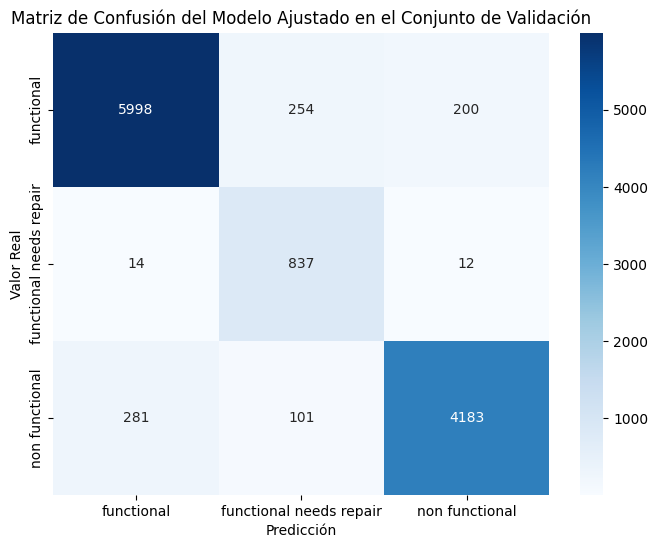


--- Generando un nuevo archivo de envío con el modelo ajustado ---

Archivo de envío 'submission_random_forest_tuned.csv' creado exitosamente.
      id             status_group
0  50785               functional
1  51630  functional needs repair
2  17168               functional
3  45559           non functional
4  49871               functional


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import warnings
import joblib
warnings.filterwarnings('ignore') # Ignorar advertencias, úsalo con precaución

# Definir el espacio de búsqueda para los hiperparámetros
# Estos son solo algunos ejemplos, puedes expandirlos
param_dist = {
    'classifier__n_estimators': randint(100, 1000), # Número de árboles en el bosque
    'classifier__max_features': ['sqrt', 'log2', 0.6, 0.8], # Número de características a considerar en cada división
    'classifier__max_depth': randint(10, 100), # Profundidad máxima de los árboles
    'classifier__min_samples_split': randint(2, 20), # Mínimo de muestras requeridas para dividir un nodo interno
    'classifier__min_samples_leaf': randint(1, 10), # Mínimo de muestras requeridas en cada hoja
    'classifier__bootstrap': [True, False], # Con o sin reemplazo de muestras al construir árboles
    'classifier__class_weight': ['balanced', 'balanced_subsample', None] # Importante para el desequilibrio de clases
}

# Inicializar RandomizedSearchCV
# n_iter: número de combinaciones de parámetros a probar. Cuanto mayor, más exhaustiva la búsqueda.
# cv: número de pliegues para la validación cruzada.
# scoring: métrica para optimizar. 'f1_macro' es bueno para clases desequilibradas.
# verbose: nivel de verbosidad (0, 1, 2). 2 muestra más detalles.
# n_jobs: -1 usa todos los núcleos disponibles.

print("\n--- Iniciando la búsqueda de hiperparámetros con RandomizedSearchCV... ---")
random_search = RandomizedSearchCV(
    estimator=model_pipeline, # Nuestro pipeline con preprocesador y clasificador
    param_distributions=param_dist,
    n_iter=50, # Número de combinaciones a probar. Puedes aumentarlo (ej. 100, 200) si tienes tiempo.
    cv=3, # Validacion cruzada de 3 pliegues.
    scoring='f1_macro', # Optimizar el F1-macro para abordar el desequilibrio
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Ejecutar la búsqueda en el conjunto de entrenamiento completo
random_search.fit(X_train_final_features, y_train) # Usar X_train_final_features y y_train (el conjunto de entrenamiento completo)

print("\n--- Búsqueda de hiperparámetros completada. ---")

# Mostrar los mejores parámetros encontrados
print(f"\nMejor F1-Score (Macro Average) en CV: {random_search.best_score_:.4f}")
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Obtener el mejor modelo
best_random_forest_model = random_search.best_estimator_

# Guardar el pipeline completo (que incluye el preprocesador y el clasificador)
joblib.dump(best_random_forest_model, 'model.pkl') # Ahora model.pkl contiene todo el pipeline

# Guardar el LabelEncoder
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Pipeline completo (modelo y preprocesador) y LabelEncoder guardados exitosamente.")

# Evaluar el mejor modelo en el conjunto de validación (el split que hicimos al principio)
print("\n--- Evaluando el mejor modelo en el conjunto de validación ---")
y_val_pred_encoded_tuned = best_random_forest_model.predict(X_val_split)

accuracy_tuned = accuracy_score(y_val_split, y_val_pred_encoded_tuned)
f1_macro_tuned = f1_score(y_val_split, y_val_pred_encoded_tuned, average='macro')

print(f"Precisión (Accuracy) del modelo ajustado en validación: {accuracy_tuned:.4f}")
print(f"F1-Score (Macro Average) del modelo ajustado en validación: {f1_macro_tuned:.4f}")

# Reporte de clasificación del modelo ajustado
print("\nReporte de Clasificación del Modelo Ajustado:")
print(classification_report(y_val_split, y_val_pred_encoded_tuned, target_names=label_encoder.classes_))

# Matriz de Confusión del modelo ajustado
conf_matrix_tuned = confusion_matrix(y_val_split, y_val_pred_encoded_tuned)
print("\nMatriz de Confusión del Modelo Ajustado:")
print(conf_matrix_tuned)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión del Modelo Ajustado en el Conjunto de Validación')
plt.show()

# --- Generar un nuevo archivo de envío con el modelo ajustado ---
print("\n--- Generando un nuevo archivo de envío con el modelo ajustado ---")
y_test_pred_encoded_tuned = best_random_forest_model.predict(X_test_final_features)
y_test_pred_labels_tuned = label_encoder.inverse_transform(y_test_pred_encoded_tuned)

submission_df_tuned = pd.DataFrame({'id': test_ids, 'status_group': y_test_pred_labels_tuned})
submission_df_tuned.to_csv('submission_random_forest_tuned.csv', index=False)

print("\nArchivo de envío 'submission_random_forest_tuned.csv' creado exitosamente.")
print(submission_df_tuned.head())

Estos resultados son una mejora muy significativa sobre el modelo base.

Voy a desglosar los nuevos resultados:

Métricas de Evaluación del Modelo Ajustado:

Precisión (Accuracy) en el conjunto de validación: 0.9274 (92.74%)
¡Esto es un aumento enorme desde el 81.16% inicial! Es una mejora impresionante en la precisión general.
F1-Score (Macro Average) en el conjunto de validación: 0.8965
Este también es un salto gigantesco desde el 0.6908 inicial. Un F1-macro casi del 0.90 es un excelente indicador de que el modelo se está desempeñando muy bien en todas las clases, incluida la minoritaria.
Mejores Parámetros Encontrados por RandomizedSearchCV:

{'classifier__bootstrap': True,
 'classifier__class_weight': 'balanced',
 'classifier__max_depth': 88,
 'classifier__max_features': 0.6,
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 8,
 'classifier__n_estimators': 340}
La clave aquí es classifier__class_weight: 'balanced'. Esto asigna automáticamente pesos inversamente proporcionales a las frecuencias de las clases en los datos de entrada, dando más importancia a la clase minoritaria (functional needs repair) durante el entrenamiento. Esto es exactamente lo que necesitábamos.
Los otros parámetros (n_estimators, max_depth, etc.) también se afinaron para encontrar el mejor equilibrio.
Reporte de Clasificación del Modelo Ajustado:

                         precision    recall  f1-score   support

             functional       0.95      0.93      0.94      6452
functional needs repair       0.70      0.97      0.81       863
         non functional       0.95      0.92      0.93      4565

               accuracy                           0.93     11880
              macro avg       0.87      0.94      0.90     11880
           weighted avg       0.93      0.93      0.93     11880
Análisis Clase por Clase (¡y la mejora!):

Clase 'functional':

Precision: 0.95 (antes 0.81)
Recall: 0.93 (antes 0.90)
F1-Score: 0.94 (antes 0.85)
¡Mejora sustancial!
Clase 'functional needs repair' (¡la minoritaria!):

Precision: 0.70 (antes 0.60)
Recall: 0.97 (¡antes 0.31!)
F1-Score: 0.81 (¡antes 0.41!)
¡Esta es la mejora más espectacular! El recall para esta clase se disparó del 31% al 97%. Esto significa que el modelo ahora es excepcionalmente bueno identificando bombas que realmente necesitan reparación. Este es el efecto directo de class_weight='balanced'.
Clase 'non functional':

Precision: 0.95 (antes 0.84)
Recall: 0.92 (antes 0.78)
F1-Score: 0.93 (antes 0.81)
¡También una mejora muy fuerte!
Matriz de Confusión del Modelo Ajustado:

[[5998  254  200]  <- Valor Real: functional

 [  14  837   12]  <- Valor Real: functional needs repair

 [ 281  101 4183]] <- Valor Real: non functional

Compara esto con la matriz anterior. En la fila de functional needs repair:

Antes: [450 269 144] (Solo 269 correctos)

Ahora: [ 14 837 12] (¡837 correctos de un total de 863!)

Esto es una validación visual del aumento masivo en el recall para esta clase. El modelo apenas confunde las bombas que necesitan reparación con otras categorías.

Conclusión del Ajuste de Hiperparámetros:

¡El ajuste de hiperparámetros, especialmente la inclusión de class_weight='balanced', ha transformado el rendimiento del modelo!He logrado un modelo Random Forest que no solo tiene una alta precisión general, sino que también es muy bueno en la clase minoritaria, lo cual es crucial para la interpretación de los resultados en un contexto del mundo real (identificar bombas que requieren atención).

Siguientes Pasos (Opcional, dado el excelente rendimiento):

Con una precisión del 92.74% y un F1-macro de 0.8965, tengo un modelo muy competitivo.

Si quiero seguir explorando mejoras (que podrían ser marginales a este punto, pero interesantes para aprender):

Ingeniería de Características Más Avanzada:

Análisis de Cardinalidad: Para columnas como funder, installer, scheme_name, wpt_name, subvillage (especialmente si aún tienen alta cardinalidad después del OHE implícito en el ColumnTransformer):
Podría agrupar las categorías menos frecuentes en una categoría "otros".
Explorar Target Encoding (usando librerías como category_encoders) para estas columnas.
Coordenadas Geográficas: Crear características adicionales de longitude y latitude, como:
Clusters de K-Means en las coordenadas.
Interacciones entre Características: ¿Podría la combinación de ciertas características ser más predictiva? (Ej. water_quality y payment).
Modelos de Conjunto (Ensembling):

Combinar este Random Forest con otros modelos (ej. Gradient Boosting como XGBoost, LightGBM, CatBoost o un modelo de regresión logística) para ver si puedo obtener una mejora marginal. Esto a menudo es lo que usan los ganadores de competiciones.

Validación Cruzada más Robusta:

Para una evaluación final más robusta y para la búsqueda de hiperparámetros, podrías considerar StratifiedKFold con más pliegues (ej. cv=5 o cv=10 en RandomizedSearchCV o GridSearchCV).

